In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import least_squares
import math

# 1. Defining Functions

## Single First Order Reaction

In [2]:
T_ref = 27
gas_const = scipy.constants.gas_constant
# [[A]_0, k(T_ref), E_a]
single_params = np.array([97.9, (7.4 * 10**(-5)) ,115.83])

def single_rate_constant(T, kT_ref, E_a):
    e = math.e**(((-E_a)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_ref * e)

def A_single (params, t,T):
    k = single_rate_constant(T, params[1], params[2])
    e = math.e**((-1)* k *t)
    return (params[0] * e)

def B_single(params, t, T, B_0):
    A = A_single(params, t, T)
    return (B_0 + params[0] - A)

## Parallel First Order Reaction

In [3]:
# [[A]0, [B]0, kB(Tref), kC(Tref), Ea,B, Ea,C]
parallel_params = [1,2,3,4,5,6]

def parallel_rate_constant(T, kT_refX, E_aX):
    e = math.e**(((-E_aX)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_refX * e)

def A_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*( k_b + k_c )*t)
    return (params[0] * e)

"""
For B and C, we are taking the assumption given in the article that: 

[B] = [A]_0\frac{k_b}{k_b + k_c} ...

where k_b and k_c would be txhe rate czonstant of the reference temperature
"""
def B_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[2] / total_k) * (1 - e)
    return (x - params[1])
    
def C_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[3] / total_k) * (1 - e)
    # [C]_0 = 100 - ([A]_0 + [B]_0
    return (x - (100 - (params[0] + params[1])))

## Single N-th Order Reaction

In [4]:
# [[A]_0, k(T_ref), E_a, N]
single_params = np.array([97.9, (7.4 * 10**(-5)) ,115.83])

def A_n_single(params, t, T):
    k = single_rate_constant(T, params[1], params[2])
    A = (params[0] ** (1 - params[3])) - k * t * (1-params[3])
    return (A ** (1/(1-params[3])))
            
def B_n_single(params, t, T):
    A = A_n_single(params, t, T)
    return (100 - A)

# 2. Test with Data (AI-Generated)

In [5]:
df = pd.read_csv('sample.csv')
df['[B]'] = df['[B] HMW'] + df['[C] LMW']
df

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278.15,99.100000,99.100000,0.000000,0.000000,0.000000
1,1,5,278.15,99.099142,99.099142,0.000240,0.000619,0.000858
2,2,5,278.15,99.098284,99.098284,0.000479,0.001237,0.001716
3,3,5,278.15,99.097425,99.097425,0.000719,0.001856,0.002575
4,4,5,278.15,99.096567,99.096567,0.000958,0.002474,0.003433
...,...,...,...,...,...,...,...,...
106,32,40,313.15,94.610996,94.610996,1.636715,2.852289,4.489004
107,33,40,313.15,94.474040,94.474040,1.686650,2.939310,4.625960
108,34,40,313.15,94.337282,94.337282,1.736512,3.026206,4.762718
109,35,40,313.15,94.200723,94.200723,1.786303,3.112975,4.899277


In [6]:
df[df['Time (months)'] == 0]

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278.15,99.1,99.1,0.0,0.0,0.0
37,0,25,298.15,99.1,99.1,0.0,0.0,0.0
74,0,40,313.15,99.1,99.1,0.0,0.0,0.0


## Single First-Order Reaction

In [7]:
lower_bounds_single_first = [80, 0, -np.inf]
upper_bounds_single_first = [100, np.inf, np.inf]


def residuals_B_single(params, combined_input_data, y_observed, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_observed - y_predicted

def batch_B_single(params, combined_input_data, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [8]:
initial_guess_single = np.array([90, (0.0005) , 120])

In [9]:
result_B = least_squares(
    residuals_B_single,
    initial_guess_single,
    args=(df, df['[B]'], 0 ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_first, upper_bounds_single_first),
    method='trf'
)

When I tried to use dogbox, the result would fluctuate like crazy, setting $[A]_0$ to be around 10%. However, the other parameters, actvation energy and rate constant are both weird in dogbox and trf


In [10]:
new_params = result_B.x
new_params

array([1.00000000e+02, 5.39733802e-10, 3.42368526e+03])

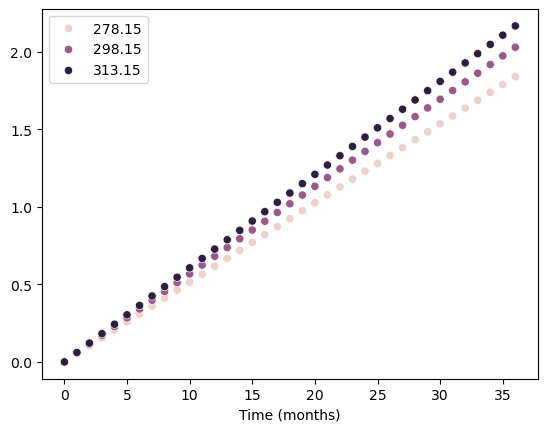

In [11]:
preds = batch_B_single(new_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

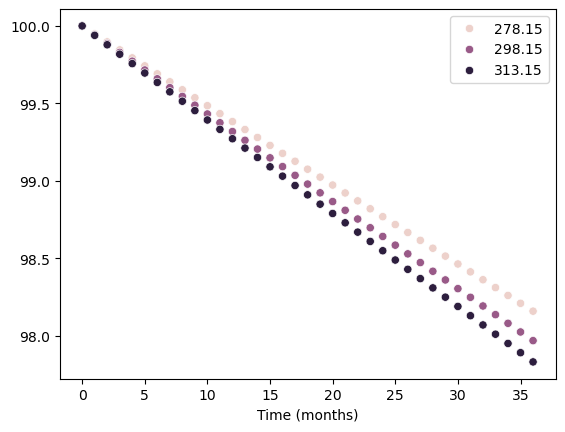

In [12]:
preds = batch_A_single(new_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

### using the supporting material's parameters

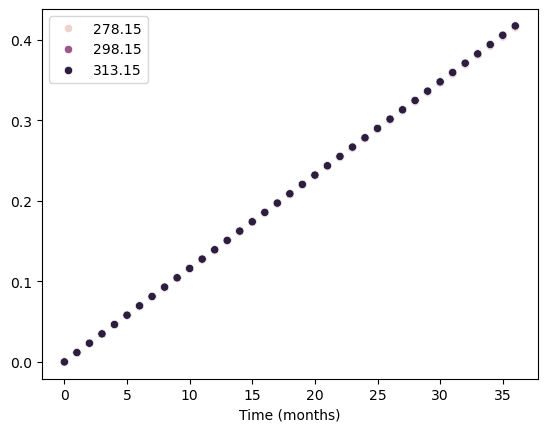

In [13]:
preds = batch_B_single(single_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

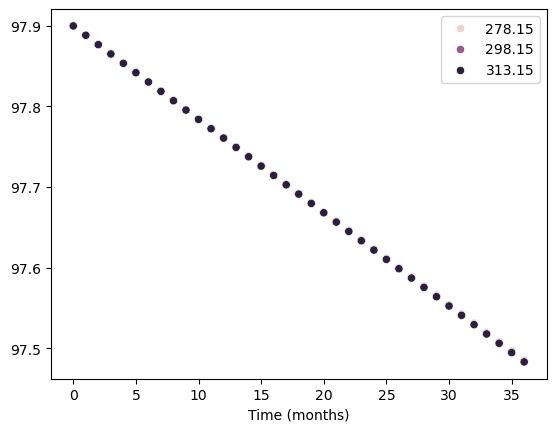

In [14]:
preds = batch_A_single(single_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

### real data

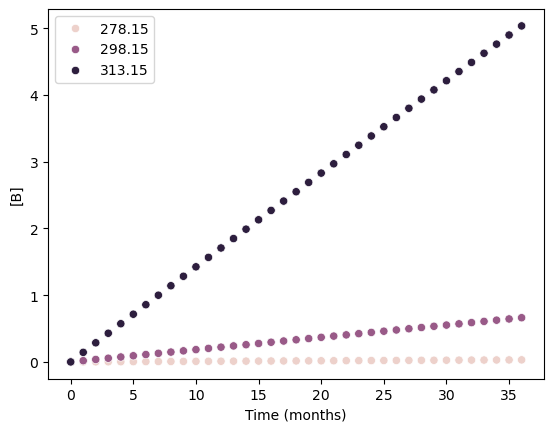

In [15]:
sns.scatterplot(x = df['Time (months)'], y = df['[B]'], hue = df['Temp (K)'])

plt.legend()
plt.show()

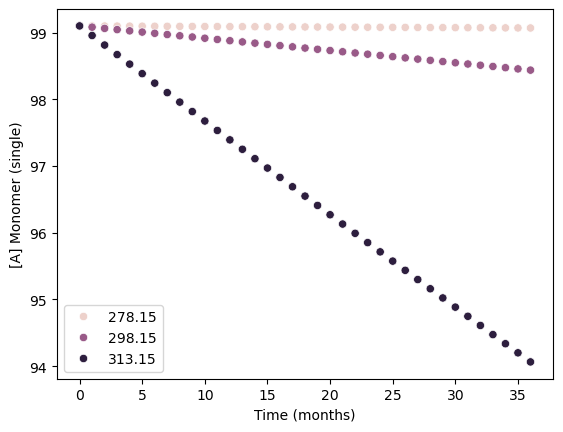

In [16]:
sns.scatterplot(x = df['Time (months)'], y = df['[A] Monomer (single)'], hue = df['Temp (K)'])

plt.legend()
plt.show()